This is a Python script performs analysis on a Google Play Store dataset. It aims to extract insights such as top app reviews, distribution of installed apps, top paid apps, etc., from the dataset.

**Dependencies:**
- pandas
- pyspark
- Apache Spark (and Hadoop for local setup)

## requirements

In [185]:
# !pip install pyspark


## import libraries

In [186]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import sys
import pandas as pd
import tempfile
import matplotlib.pyplot as plt

## Determine the encoding of your system

In [187]:
encoding = sys.getdefaultencoding()


## Initialize SparkSession

In [188]:
spark = SparkSession.builder \
    .appName("playstore") \
    .config("spark.driver.extraClassPath", "/path/to/spark-excel_2.12-0.13.1.jar") \
    .config("spark.executor.extraClassPath", "/path/to/spark-excel_2.12-0.13.1.jar") \
    .getOrCreate()


## create dataframe

In [189]:
df = spark.read.csv("data/googlestore.csv", header=True, sep=",", escape='"')

In [190]:
print(df.count())

10841


In [191]:
print(df.show(1))

+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+-----------+------------+
|                 App|      Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|      Genres|   Last Updated|Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+-----------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M| 10,000+|Free|    0|      Everyone|Art & Design|January 7, 2018|      1.0.0|4.0.3 and up|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+-----------+------------+
only showing top 1 row

None


## check schema

In [192]:
print(df.printSchema())

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)

None


## data cleaning


In [193]:
df = df.drop('Size', 'Content Rating', 'Last Updated', 'Current Ver', 'Android Ver')

In [194]:
print(df)

DataFrame[App: string, Category: string, Rating: string, Reviews: string, Installs: string, Type: string, Price: string, Genres: string]


In [195]:
print(df.show(2))

+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|                 App|      Category|Rating|Reviews|Installs|Type|Price|              Genres|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 10,000+|Free|    0|        Art & Design|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967|500,000+|Free|    0|Art & Design;Pret...|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
only showing top 2 rows

None


In [196]:
print(df.printSchema())

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Genres: string (nullable = true)

None


In [197]:
df = df.withColumn('Reviews', col('Reviews').cast(IntegerType())) \
       .withColumn("Installs", regexp_replace(col('Installs'), "[^0-9]", "")) \
       .withColumn('Installs', col('Installs').cast(IntegerType())) \
       .withColumn("Price", regexp_replace(col('Price'), "[$]", "")) \
       .withColumn('Price', col('Price').cast(IntegerType())) \
       .withColumn("Rating", regexp_replace(col('Rating'), "[$]", "")) \
       .withColumn('Rating', col('Rating').cast(IntegerType()))


In [198]:
print(df.show(5))

+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|                 App|      Category|Rating|Reviews|Installs|Type|Price|              Genres|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|Photo Editor & Ca...|ART_AND_DESIGN|     4|    159|   10000|Free|    0|        Art & Design|
| Coloring book moana|ART_AND_DESIGN|     3|    967|  500000|Free|    0|Art & Design;Pret...|
|U Launcher Lite �...|ART_AND_DESIGN|     4|  87510| 5000000|Free|    0|        Art & Design|
|Sketch - Draw & P...|ART_AND_DESIGN|     4| 215644|50000000|Free|    0|        Art & Design|
|Pixel Draw - Numb...|ART_AND_DESIGN|     4|    967|  100000|Free|    0|Art & Design;Crea...|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
only showing top 5 rows

None


In [199]:
df.createOrReplaceTempView("apps")

##  SQL Select query

**load and activate the SQL extention to allow us to execute SQL in notebook**

In [200]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [201]:
spark.sql("SELECT * from apps") \
.show()

+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|                 App|      Category|Rating|Reviews|Installs|Type|Price|              Genres|
+--------------------+--------------+------+-------+--------+----+-----+--------------------+
|Photo Editor & Ca...|ART_AND_DESIGN|     4|    159|   10000|Free|    0|        Art & Design|
| Coloring book moana|ART_AND_DESIGN|     3|    967|  500000|Free|    0|Art & Design;Pret...|
|U Launcher Lite �...|ART_AND_DESIGN|     4|  87510| 5000000|Free|    0|        Art & Design|
|Sketch - Draw & P...|ART_AND_DESIGN|     4| 215644|50000000|Free|    0|        Art & Design|
|Pixel Draw - Numb...|ART_AND_DESIGN|     4|    967|  100000|Free|    0|Art & Design;Crea...|
|Paper flowers ins...|ART_AND_DESIGN|     4|    167|   50000|Free|    0|        Art & Design|
|Smoke Effect Phot...|ART_AND_DESIGN|     3|    178|   50000|Free|    0|        Art & Design|
|    Infinite Painter|ART_AND_DESIGN|     4|  36815| 1000000

## top reviews given to apps

In [202]:
reviews = spark.sql("SELECT App, SUM(Reviews) AS TotalReviews FROM apps GROUP BY App ORDER BY TotalReviews DESC")

In [203]:
reviews.show()

+--------------------+------------+
|                 App|TotalReviews|
+--------------------+------------+
|           Instagram|   266241989|
|  WhatsApp Messenger|   207348304|
|      Clash of Clans|   179558781|
|Messenger ��� Tex...|   169932272|
|      Subway Surfers|   166331958|
|    Candy Crush Saga|   156993136|
|            Facebook|   156286514|
|         8 Ball Pool|    99386198|
|        Clash Royale|    92530298|
|            Snapchat|    68045010|
|     Viber Messenger|    56675481|
|UC Browser - Fast...|    53140694|
|             YouTube|    51278853|
|        Temple Run 2|    48710930|
|Sniper 3D Gun Sho...|    46022233|
|      My Talking Tom|    44668928|
|Duolingo: Learn L...|    44047832|
|       Google Photos|    43423827|
|Clean Master- Spa...|    42916526|
|                 Pou|    41939801|
+--------------------+------------+
only showing top 20 rows



In [204]:
# Convert Spark DataFrame to Pandas DataFrame
df_reviews = reviews.toPandas()

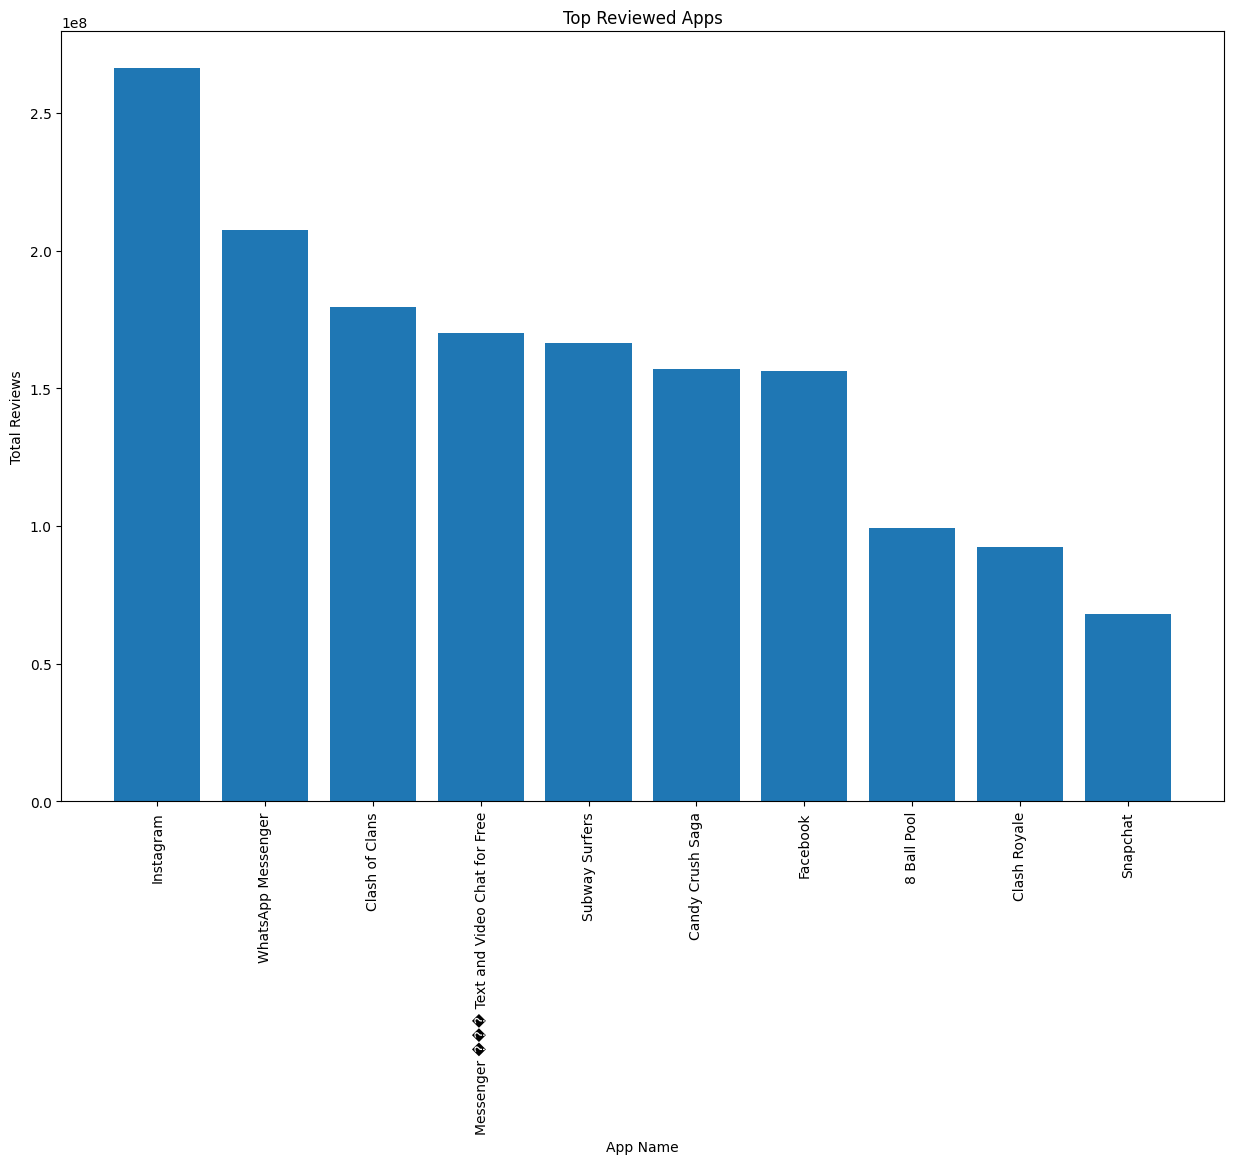

In [205]:
# Create a bar chart of the top reviewed apps
plt.figure(figsize=(15, 10))
plt.bar(df_reviews['App'][:10], df_reviews['TotalReviews'][:10])
plt.title('Top Reviewed Apps')
plt.xlabel('App Name')
plt.ylabel('Total Reviews')
plt.xticks(rotation=90)
plt.show()

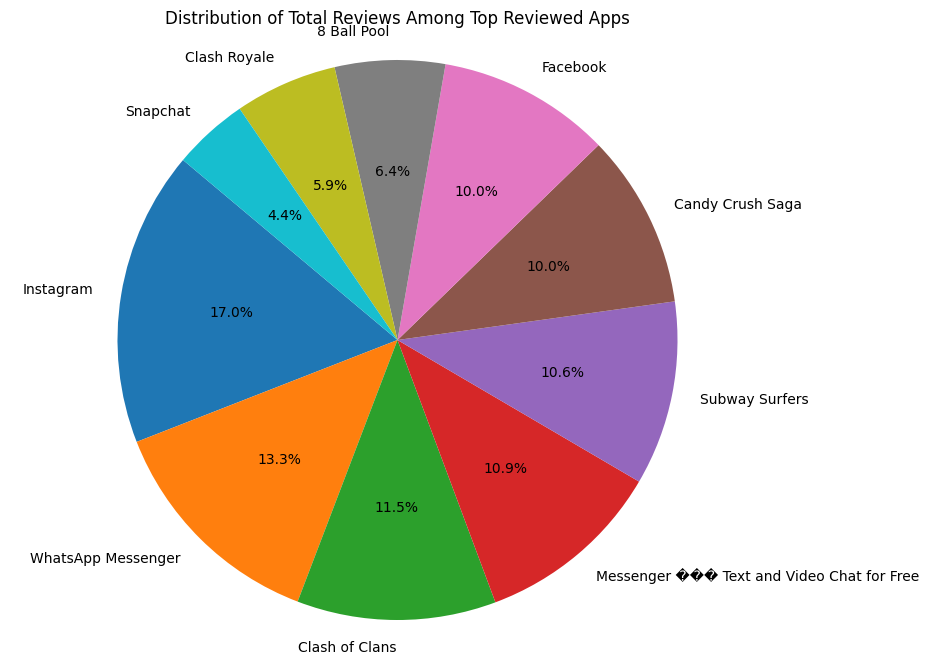

In [206]:
# Top 10 reviewed apps
top_10_apps = df_reviews.head(10)

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_10_apps['TotalReviews'], labels=top_10_apps['App'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Total Reviews Among Top Reviewed Apps')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

## top 10 installs apps

In [207]:
installs = spark.sql("SELECT App, Type, SUM(Installs) FROM apps GROUP BY 1,2 ORDER BY 3 DESC")


In [208]:
installs.show()

+--------------------+----+-------------+
|                 App|Type|sum(Installs)|
+--------------------+----+-------------+
|      Subway Surfers|Free|   6000000000|
|           Instagram|Free|   4000000000|
|        Google Drive|Free|   4000000000|
|            Hangouts|Free|   4000000000|
|       Google Photos|Free|   4000000000|
|         Google News|Free|   4000000000|
|    Candy Crush Saga|Free|   3500000000|
|  WhatsApp Messenger|Free|   3000000000|
|               Gmail|Free|   3000000000|
|        Temple Run 2|Free|   3000000000|
|Skype - free IM &...|Free|   3000000000|
|Google Chrome: Fa...|Free|   3000000000|
|Messenger ��� Tex...|Free|   3000000000|
|Maps - Navigate &...|Free|   3000000000|
|     Viber Messenger|Free|   2500000000|
|            Snapchat|Free|   2000000000|
|imo free video ca...|Free|   2000000000|
|            Facebook|Free|   2000000000|
|                 Pou|Free|   2000000000|
|             YouTube|Free|   2000000000|
+--------------------+----+-------

In [209]:
# Convert Spark DataFrame to Pandas DataFrame
df_installs = installs.toPandas()

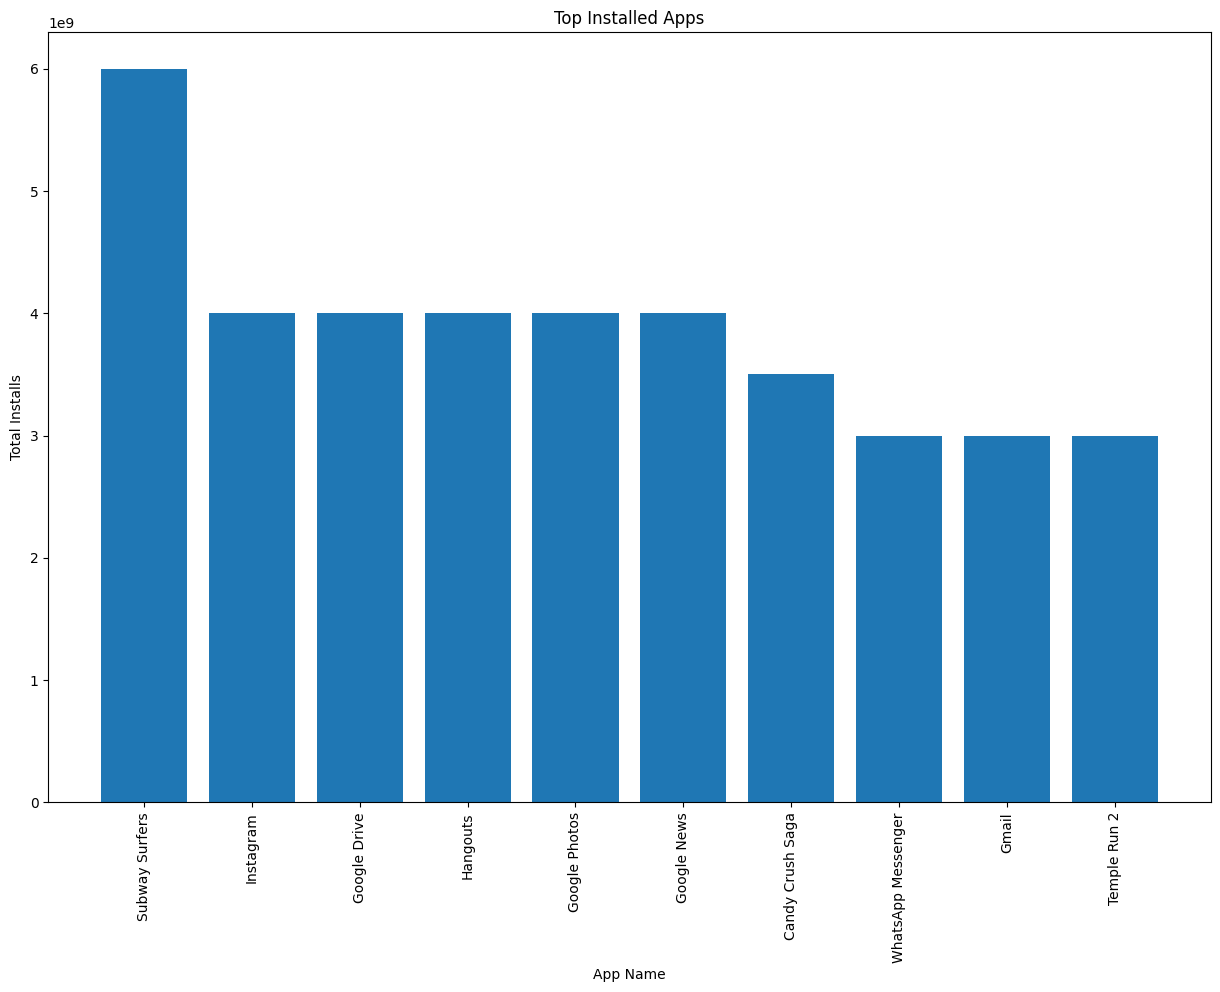

In [210]:
# Create a bar chart of the top installed apps
plt.figure(figsize=(15, 10))
plt.bar(df_installs['App'][:10], df_installs['sum(Installs)'][:10])
plt.title('Top Installed Apps')
plt.xlabel('App Name')
plt.ylabel('Total Installs')
plt.xticks(rotation=90)
plt.show()


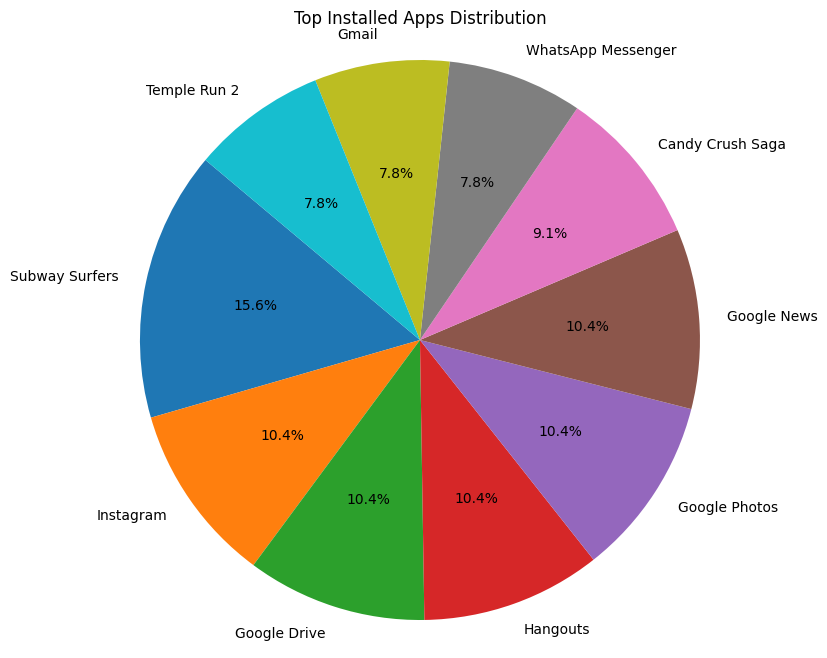

In [211]:
# Extracting relevant data for the pie chart
top_apps = df_installs['App'][:10]
installs = df_installs['sum(Installs)'][:10]

# Create a pie chart of the top installed apps
plt.figure(figsize=(10, 8))
plt.pie(installs, labels=top_apps, autopct='%1.1f%%', startangle=140)
plt.title('Top Installed Apps Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Category-wise Distribution of Installed Apps

In [212]:
Category = spark.sql("SELECT Category, SUM(Installs) FROM apps GROUP BY 1 ORDER BY 2 DESC")


In [213]:
Category.show()

+-------------------+-------------+
|           Category|sum(Installs)|
+-------------------+-------------+
|               GAME|  35086024415|
|      COMMUNICATION|  32647276251|
|       PRODUCTIVITY|  14176091369|
|             SOCIAL|  14069867902|
|              TOOLS|  11452771915|
|             FAMILY|  10258263505|
|        PHOTOGRAPHY|  10088247655|
| NEWS_AND_MAGAZINES|   7496317760|
|   TRAVEL_AND_LOCAL|   6868887146|
|      VIDEO_PLAYERS|   6222002720|
|           SHOPPING|   3247848785|
|      ENTERTAINMENT|   2869160000|
|    PERSONALIZATION|   2325494782|
|BOOKS_AND_REFERENCE|   1921469576|
|             SPORTS|   1751174498|
| HEALTH_AND_FITNESS|   1583072512|
|           BUSINESS|   1001914865|
|            FINANCE|    876648734|
|          EDUCATION|    871452000|
|MAPS_AND_NAVIGATION|    724281890|
+-------------------+-------------+
only showing top 20 rows



In [214]:
# Convert Spark DataFrame to Pandas DataFrame
df_Category = Category.toPandas()

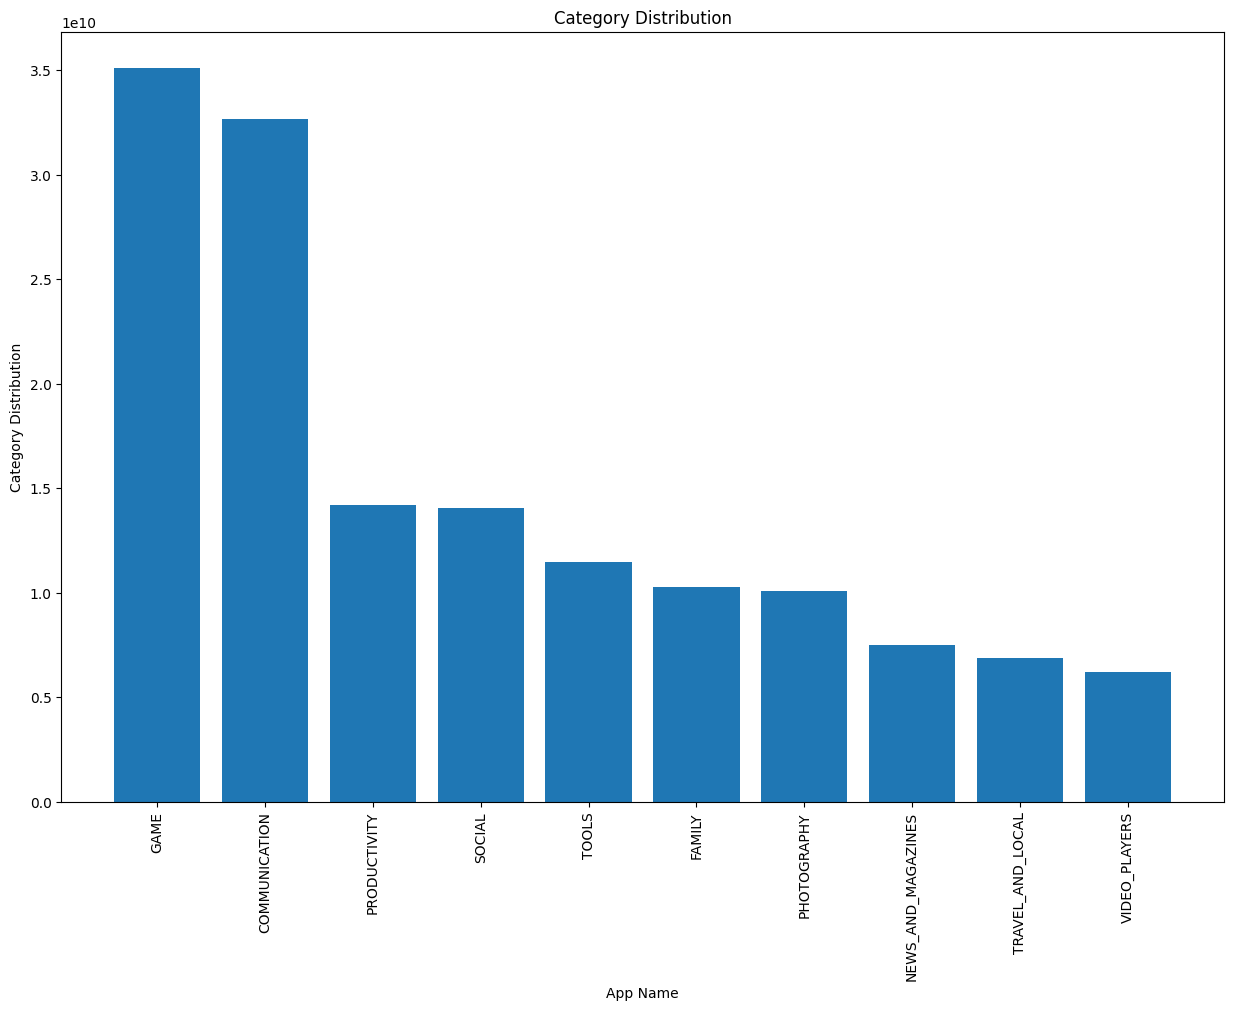

In [215]:
# Create a bar chart of the top installed apps
plt.figure(figsize=(15, 10))
plt.bar(df_Category['Category'][:10], df_Category['sum(Installs)'][:10])
plt.title('Category Distribution')
plt.xlabel('App Name')
plt.ylabel('Category Distribution')
plt.xticks(rotation=90)
plt.show()


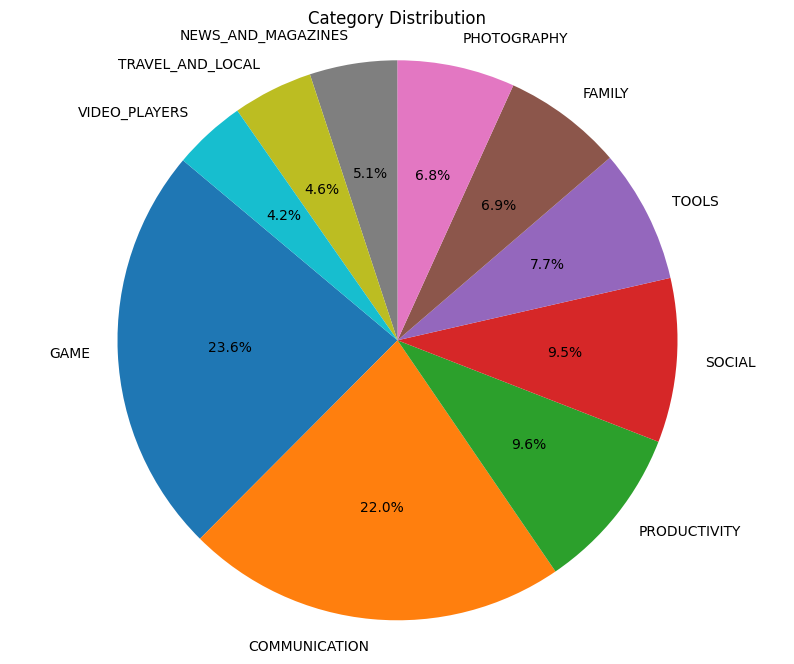

In [216]:
# Extracting relevant data for the pie chart
top_apps = df_Category['Category'][:10]
installs = df_Category['sum(Installs)'][:10]

# Create a pie chart of the top installed apps
plt.figure(figsize=(10, 8))
plt.pie(installs, labels=top_apps, autopct='%1.1f%%', startangle=140)
plt.title('Category Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Top Paid Apps

In [217]:
paid = spark.sql("SELECT App, SUM(Price) FROM apps WHERE Type = 'Paid' GROUP BY 1 ORDER BY 2 DESC")


In [218]:
paid.show()

+--------------------+----------+
|                 App|sum(Price)|
+--------------------+----------+
|I'm Rich - Trump ...|       400|
|           I am Rich|       399|
|most expensive ap...|       399|
|  I AM RICH PRO PLUS|       399|
|      I am Rich Plus|       399|
|   I Am Rich Premium|       399|
|  I am rich(premium)|       399|
|       I Am Rich Pro|       399|
|          I am Rich!|       399|
|       ?��? I'm rich|       399|
|I am rich (Most e...|       399|
|I'm Rich/Eu sou R...|       399|
|           I am rich|       399|
|         Eu Sou Rico|       394|
|           I Am Rich|       389|
| I am extremely Rich|       379|
|       I am rich VIP|       299|
|        EP Cook Book|       200|
|Vargo Anesthesia ...|       158|
|       cronometra-br|       154|
+--------------------+----------+
only showing top 20 rows



In [219]:
# Convert Spark DataFrame to Pandas DataFrame
df_paid = paid.toPandas()

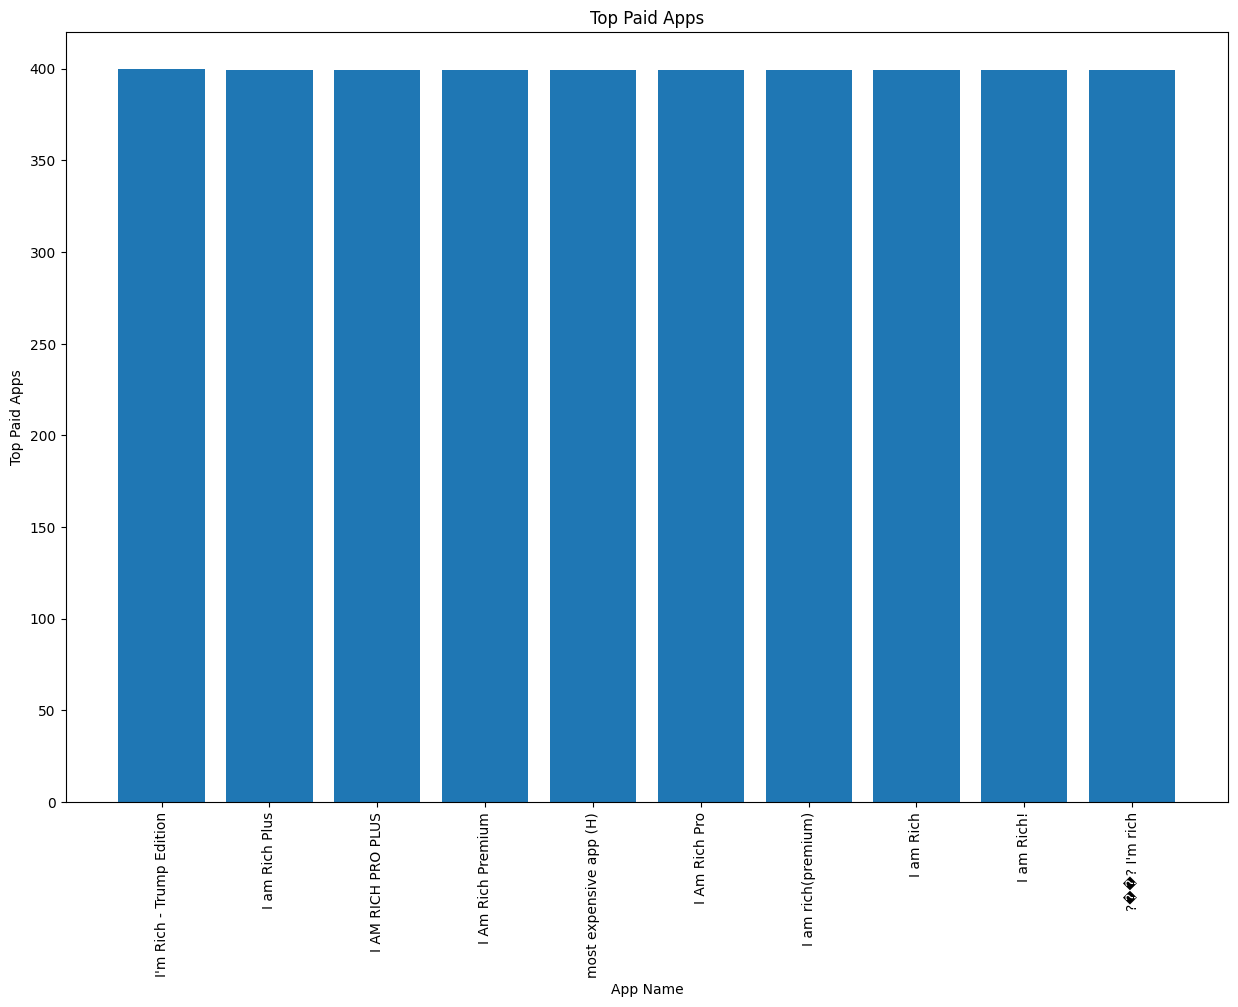

In [220]:
# Create a bar chart of the top installed apps
plt.figure(figsize=(15, 10))
plt.bar(df_paid['App'][:10], df_paid['sum(Price)'][:10])
plt.title('Top Paid Apps')
plt.xlabel('App Name')
plt.ylabel('Top Paid Apps')
plt.xticks(rotation=90)
plt.show()


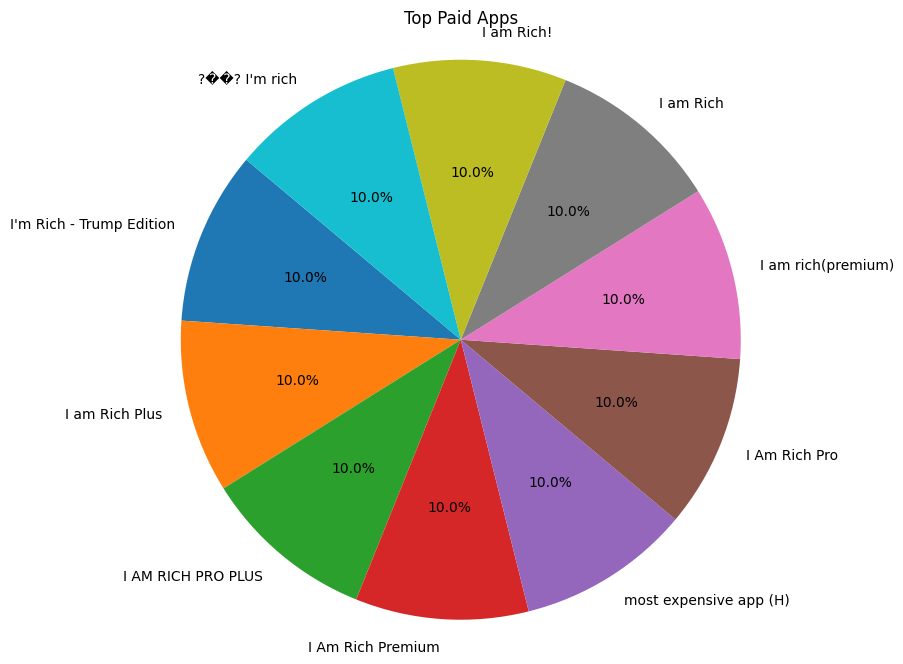

In [221]:
# Extracting relevant data for the pie chart
top_apps = df_paid['App'][:10]
installs = df_paid['sum(Price)'][:10]

# Create a pie chart of the top installed apps
plt.figure(figsize=(10, 8))
plt.pie(installs, labels=top_apps, autopct='%1.1f%%', startangle=140)
plt.title('Top Paid Apps')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Top Paid Rating Apps


In [228]:
rating_paid = spark.sql("SELECT App, SUM(Rating) AS TotalRating FROM apps WHERE Type = 'Paid' GROUP BY App ORDER BY TotalRating DESC")

In [229]:
rating_paid.show()

+--------------------+-----------+
|                 App|TotalRating|
+--------------------+-----------+
| Facetune - For Free|         12|
|Dr. Panda & Toto'...|         12|
|Human Anatomy Atl...|         12|
|Cardiac diagnosis...|          8|
|           Pedi STAT|          8|
|Vargo Anesthesia ...|          8|
|Diabetes & Diet T...|          8|
|           Minecraft|          8|
|         AnatomyMapp|          8|
|     Toca Life: City|          8|
|Blood Pressure Co...|          8|
|    The Game of Life|          8|
|         Pocket Yoga|          8|
| Essential Anatomy 3|          8|
|    Sago Mini Babies|          8|
|  PTA Content Master|          8|
|          HD Widgets|          8|
|Beautiful Widgets...|          8|
|  iBP Blood Pressure|          8|
|TurboScan: scan d...|          8|
+--------------------+-----------+
only showing top 20 rows



In [230]:
# Convert Spark DataFrame to Pandas DataFrame
df_rating_paid = rating_paid.toPandas()

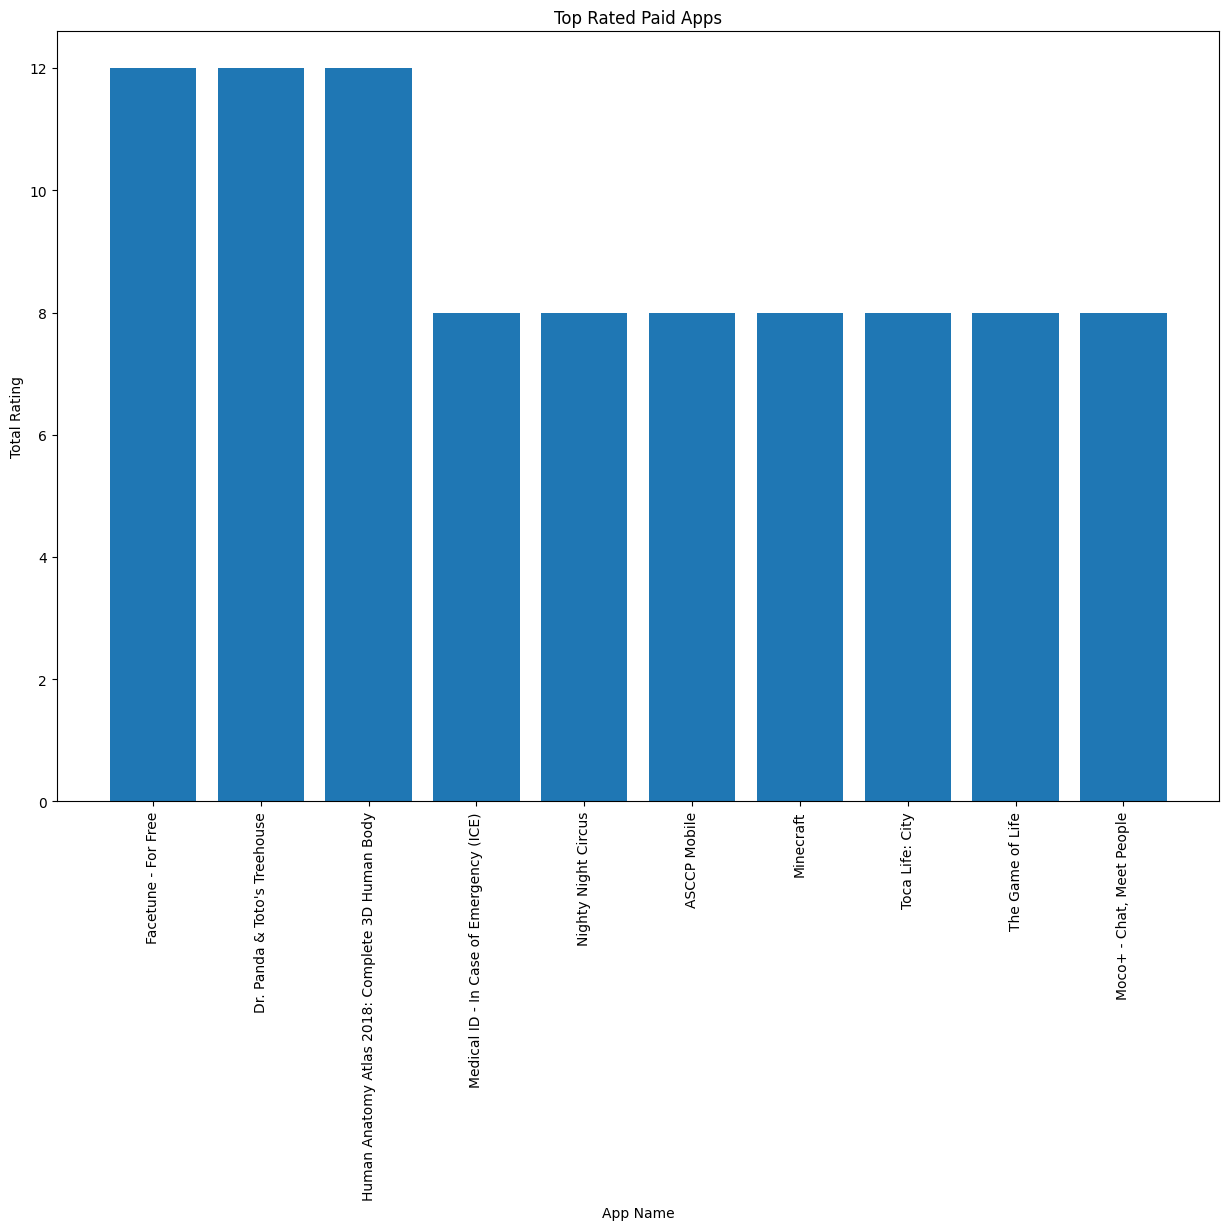

In [234]:
# Create a bar chart of the top rated paid apps
plt.figure(figsize=(15, 10))
plt.bar(df_rating_paid['App'][:10], df_rating_paid['TotalRating'][:10])
plt.title('Top Rated Paid Apps')
plt.xlabel('App Name')
plt.ylabel('Total Rating')
plt.xticks(rotation=90)
plt.show()


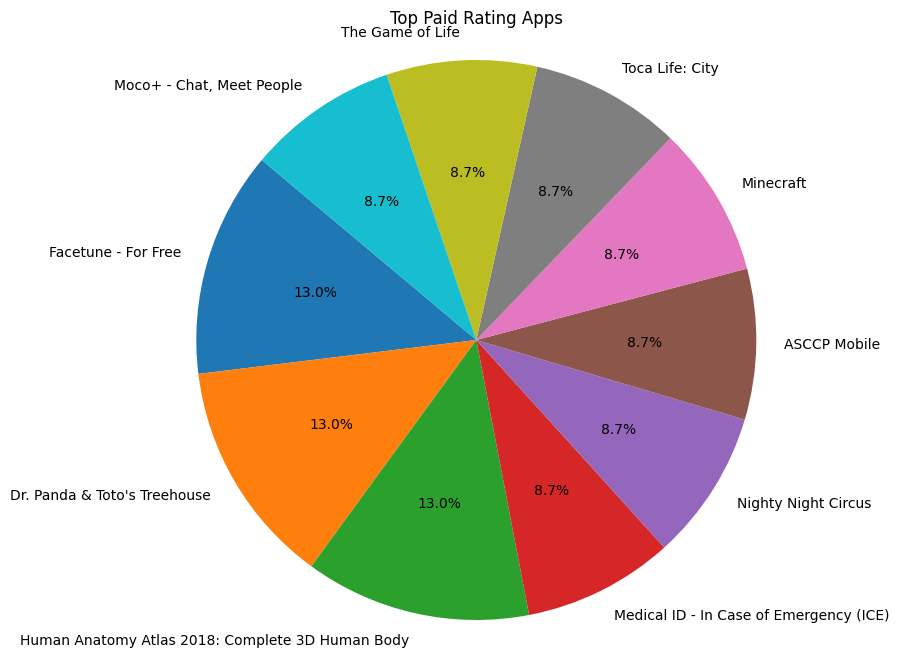

In [236]:
# Extracting relevant data for the pie chart
top_apps = df_rating_paid['App'][:10]
installs = df_rating_paid['TotalRating'][:10]

# Create a pie chart of the top installed apps
plt.figure(figsize=(10, 8))
plt.pie(installs, labels=top_apps, autopct='%1.1f%%', startangle=140)
plt.title('Top Paid Rating Apps')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
